This post is a continuation of the [Neural Network](http://lakshgupta.github.io/2015/06/12/NeuralNetwork/) post where we learned about the basics of a neural network and applied it on the handwritten digit recognition problem. Here we'll cover the following topics which can help our neural network to perform better in terms of the accuracy of the model. 
- [Rectified linear unit (ReLU) function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
- [Softmax function](https://en.wikipedia.org/wiki/Softmax_function)
- [Mini-batch gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

So let's get started!

In [1]:
using MNIST
using PyPlot

Our main algorithm for learning will be the same, i.e. backpropagation. I have re-structured the program to have replaceable components to make the experiment easy. There is a small change in the architecture of the neural network:
- output layer will always be using the Softmax activation function
- rest of all the layers we'll either use Sigmoid or ReLU activation function

![sigmoid](files/img/nn/softmax_nn.jpg)

<h4 class="section-heading">ReLU Activation Function : $$f(x) = max(0, x)$$</h4>

![sigmoid_relu](files/img/nn/sigmoid_relu.png)


We have already seen the sigmoid function instead of which we'll use ReLU activation function for the input and hidden layers in the current neural network architecture because it is faster and does not suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).  

>- Biological plausibility: One-sided, compared to the antisymmetry of [tanh](https://en.wikipedia.org/wiki/Hyperbolic_function#Tanh).
>- Sparse activation: For example, in a randomly initialized network, only about 50% of hidden units are activated (having a non-zero output).
>- Efficient gradient propagation: No [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) or exploding effect.
>- Efficient computation: Only comparison, addition and multiplication.
>
>For the first time in 2011, the use of the rectifier as a non-linearity has been shown to enable training deep supervised neural networks without requiring unsupervised pre-training. Rectified linear units, compared to [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function or similar activation functions, allow for faster and effective training of deep neural architectures on large and complex datasets.
>
>Potential problems:
Non-differentiable at zero: however it is differentiable at any point arbitrarily close to 0.
<p>- <a href="https://en.wikipedia.org/wiki/Rectifier_(neural_networks)">Wikipedia</a></p>


>"What neuron type should I use?" Use the ReLU non-linearity, be careful with your learning rates and possibly monitor the fraction of "dead" units in a network. If this concerns you, give Leaky ReLU or Maxout a try. Never use sigmoid. Try tanh, but expect it to work worse than ReLU/Maxout.
<p>- <a href="http://cs231n.github.io/neural-networks-1/">Andrej Karpathy</a></p>

In [2]:
# ReLU function
function relu(z::Matrix{Float64})
    return max(0.0, z);
end

relu (generic function with 1 method)

In [3]:
# sigmoid function
function sigmoid(z::Matrix{Float64})
    g = 1.0 ./ (1.0 + exp(-z));
    return g;
end

sigmoid (generic function with 1 method)

<h4 class="section-heading">Softmax Activation Function : $$f_i(x) = \frac{e^{x_i}}{\sum_k e^{x_k}}$$</h4>

Using softmax function gives us normalized class probabilities. Softmax activation function takes the input, exponentiating the input gives us unnormalized probabilities and then it uses a normalization factor to result in normalized probabilities. Hence the output for each class lies between $0$ and $1$, and the sum of all the class probabilities is equal to $1$.

In [4]:
function forwardNN(activationFn::Function, x::Matrix{Float64})
    global network;
    # collect input for each layer
    # the last element will be the output from the neural network
    inputs = Matrix{Float64}[];
    # initialize input vector with the actual data
    push!(inputs, x);
    for layer in 1:length(network)-1
        push!(inputs, activationFn((inputs[layer]*network[layer][1]) .+ network[layer][2]))
    end
    # softmax on last layer
    score = inputs[length(network)]*network[length(network)][1] .+ network[length(network)][2]
    exp_scores = exp(score);
    probs = exp_scores ./ sum(exp_scores, 2); 

    return inputs,probs;
end

forwardNN (generic function with 1 method)

<h4 class="section-heading">Cost Function: $J$</h4>

The last time we converted each output to an array of size $10$ with $1$ on the index representing the actual output and $0$ on the rest of the indices. Because of this we used a special case of the cross-entropy cost function where number of classes is equal to 2 assuming all of the output classes are independent of each other:

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{i=1}^{k}[ y^{(i)}_k\log{(h_{\theta}(x^{(i)})_k)} + (1-y^{(i)}_k)\log({1-(h_{\theta}(x^{(i)}))_k)}]$$

>If we have multiple independent binary attributes by which to classify the data, we can use a network with multiple logistic outputs and cross-entropy error. For multinomial classification problems (1-of-n, where n > 2) we use a network with n outputs, one corresponding to each class, and target values of 1 for the correct class, and 0 otherwise. Since these targets are not independent of each other, however, it is no longer appropriate to use logistic output units. The corect generalization of the logistic sigmoid to the multinomial case is the softmax activation function.
<p>- <a href="https://www.willamette.edu/~gorr/classes/cs449/classify.html">Genevieve (Jenny) B. Orr</a></p>

Now since we are using softmax in the output layer, the probability for one class is divided by the sum of probabilities for all the classes. Hence we will used the generalized cross entropy cost function:

\begin{align}
J(\theta) = - \left[ \sum_{i=1}^{m} \sum_{k=1}^{K}  1\left\{y^{(i)} = k\right\} \log \frac{\exp(\theta^{(k)\top} h_{W,b}(x^{(i)}))}{\sum_{j=1}^K \exp(\theta^{(j)\top} h_{W,b}(x)^{(i)}))}\right].
\end{align}

where $h_{W,b}(x)$ is the input from the last hidden layer. In the code, you'll see that I have also applied $L^2$ regularization.

In [5]:
function costFunction(truth::Vector{Float64}, probability::Matrix{Float64})
    global network;
    # compute the loss: average cross-entropy loss and regularization
    m = size(truth,1)
    
    corect_logprobs = [-log(probability[j,convert(Int32, truth[j])]) for j in 1:m];
    data_loss = sum(corect_logprobs)/m;
    
    reg_loss = 0;
    for j in 1:length(network)
        reg_loss = reg_loss + 0.5*lambda*sum(network[j][1].^2)/m;
    end
    
    loss = data_loss + reg_loss;
    return loss;
end

costFunction (generic function with 1 method)

In [6]:
# gradient of the sigmoid function evaluated at a
function sigmoidGradient(a::Matrix{Float64})
  return a.*(1-a);
end

sigmoidGradient (generic function with 1 method)

In [7]:
# gradient of the ReLU function evaluated at a
function reluGradient(a::Matrix{Float64})
    grad = ones(a);
    grad[a.<=0] = 0;
    return grad;
end

reluGradient (generic function with 1 method)

The algorithm to learn the parameters is still the same, backpropagation. The previous post has a detailed explanation of how the backpropagation algorithm works, the use of chain rule to backpropagate the error. The derivation of the cost function hence can be similarly computed. This write-up from Tambet Matiisen's is also a nice reference: [word2vec gradients](https://courses.cs.ut.ee/MTAT.03.277/2015_fall/uploads/Main/word2vec.pdf)

>In the probabilistic interpretation, we are therefore minimizing the negative log likelihood of the correct class, which can be interpreted as performing Maximum Likelihood Estimation (MLE). 
<p>- <a href="http://cs231n.github.io/linear-classify/">Andrej Karpathy</a></p>

The last layer, as before, computes the error by taking the difference between the estimated prediction and the actual prediction. The change here is that the actual prediction is always $1$ otherwise $0$ since we are now dealing with the normalized class probabilities.

> Note that this loss function can be
understood as a special case of the cross-entropy measurement between two probabilistic
distributions.
Let us now derive the update equation of the weights between hidden and output layers.
Take the derivative of $E$ with regard to $j$-th unit’s net input $u_j$ , we obtain

>$$\dfrac{\partial E}{\partial u_j} = y_j − t_j := e_j \tag{8}$$

>where $t_j = 1(j = j∗)$, i.e., $t_j$ will only be $1$ when the $j$-th unit is the actual output word,
otherwise $t_j$ = 0. Note that this derivative is simply the prediction error $e_j$ of the output
layer.
><p>- <a href="http://arxiv.org/abs/1411.2738">Xin Rong</a></p>

In [8]:
function backwardNN(activationFnGrad::Function, a::Vector{Matrix{Float64}}, y::Vector{Float64}, dscores::Matrix{Float64})
    global network;
    m = size(y,1);
    delta = Array(Matrix{Float64}, 1,length(network));
    # start from the last layer to backpropagate the error
    # compute the gradient on scores
    for j in 1:size(dscores,1)
        dscores[j,convert(Int32, y[j])] -= 1;
    end
    delta[length(network)] = dscores/m; # normalization factor
    # backpropagate
    for j in length(network)-1:-1:1
        delta[j] = delta[j+1]*network[j+1][1]'.*activationFnGrad(a[j+1]);
    end
    return delta;
end

backwardNN (generic function with 1 method)

In [9]:
function updateThetas(a::Vector{Matrix{Float64}}, delta::Matrix{Matrix{Float64}})
    global network;
    for j in 1:length(network)
        # update theta
        network[j][1] = network[j][1] - alpha*(a[j]'*delta[j] + lambda*network[j][1])
        # update bias
        network[j][2] =  network[j][2] - alpha*sum(delta[j],1);
    end
end

updateThetas (generic function with 1 method)

In [10]:
function predict(activationFn, data::Matrix{Float64})
    activation, probs = forwardNN(activationFn, data);
    predicted_class = [indmax(probs[i,:]) for i in 1:size(probs,1)]
    return predicted_class;
end

predict (generic function with 1 method)

In [11]:
function accuracy(truth, prediction)
    correct = 0;
    for i in 1:length(truth)
        if truth[i] == prediction[i]
            correct = correct + 1;
        end
    end
    println("training accuracy: ", correct/length(truth)*100);
end

accuracy (generic function with 1 method)

<h2 class="section-heading">Training a model</h2>

Based on the new structure of the program, we'll build up our neural network and train our model.

<h4 class="section-heading">Load Data</h4>

In [12]:
# ===================
# load training data
# ===================
X,Y = traindata(); #X:(784x60000), y:(60000x1)
X /= 255.0; # scale the input between 0 and 1
X = X'; #X:(60000X784)
Y = Y+1; # adding 1 to handle index, hence value 1 represent digit 0 now
# number of instances
println(size(Y,1));

60000


<h4 class="section-heading">Define Network</h4>

In [13]:
inputLayerSize = size(X,2);
hiddenLayerSize = 100;
outputLayerSize = 10;

In [14]:
# define a network
network = [];

# add first layer to the network
layer1 = Array(Matrix{Float64}, 1,2)
#theta1
layer1[1] = 0.01*randn(inputLayerSize, hiddenLayerSize); 
#bias1
layer1[2] = zeros(1, hiddenLayerSize); 
push!(network,layer1);

# add second layer to the network
layer2 = Array(Matrix{Float64}, 1,2)
#theta2
layer2[1] = 0.01*randn(hiddenLayerSize, outputLayerSize); 
#bias2
layer2[2] = zeros(1, outputLayerSize); 
push!(network,layer2);

<h4 class="section-heading">Training: Mini-batch gradient descent</h4>


The last time we used gradient descent to train our model. In this implementation we'll switch to Mini-Batch gradient descent algorithm which is not much different from regular gradient descent. It's just that instead of working on the whole dataset we'll work on a smaller dataset in each iteration. Because of this change our training algorithm will become computationally faster since large datasets are difficult to handle in memory which makes vectorization much less efficient. 

>In particular, suppose that our error function is particularly pernicious and has a bunch of little valleys. If we used the entire training set to compute each gradient, our model would get stuck in the first valley it fell into (since it would register a gradient of 0 at this point). If we use smaller mini-batches, on the other hand, we'll get more noise in our estimate of the gradient. This noise might be enough to push us out of some of the shallow valleys in the error function. 
><p>- <a href="https://www.quora.com/Intuitively-how-does-mini-batch-size-affect-the-performance-of-gradient-descent">Quora</a></p>

One thing to take care in the while training is that mini-batches need to be balanced for classes. Otherwise the estimation of the gradient using mini-batch gradient descent would be way off then the gradient calculated using the whole dataset.

In [15]:
alpha = 1e-0; # step size
lambda = 1e-3; # regularization factor
numItr = 1500;
costSamplingItr = 10;
batchSize = convert(Int32,floor(size(X,1)/10));
J = [];
for itr in 1:numItr
    # take next batch of random instances 
    minibatch = collect(rand(1:size(X,1), batchSize));
    # feedforward
    activations, probs = forwardNN(relu, X[minibatch,:]); 
    # cost
    if itr%costSamplingItr == 0
        activationsX, probsX = forwardNN(relu, X); 
        push!(J, costFunction(Y, probsX));
    end
    # backpropagation
    newThetas = backwardNN(reluGradient, activations, Y[minibatch], probs);
    # update parameters
    updateThetas(activations, newThetas);
end

The code above is using ReLU activation function for the hidden layers but the program is modular enough to let us experiment with different activation functions, for example sigmoid. 

<h2 class="section-heading">Prediction and Accuracy</h2>

In [16]:
accuracy(Y, predict(relu, X));

training accuracy: 97.81166666666667


This is around 10% improvement over our previous implementation.

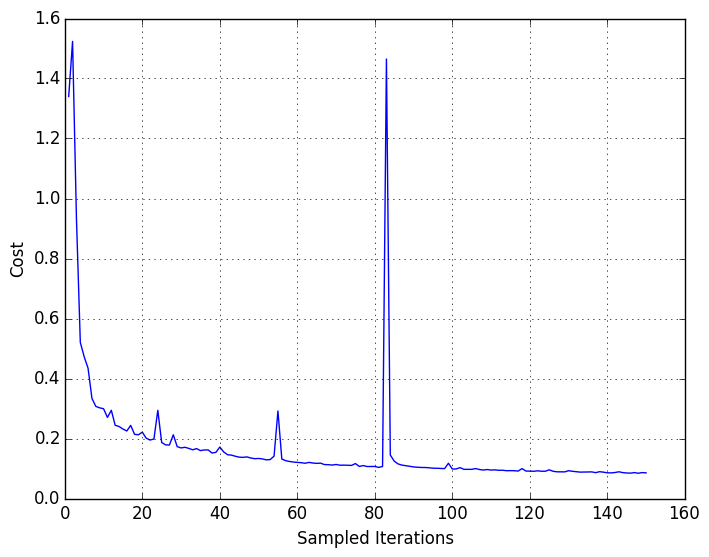

In [17]:
# plot the cost per iteration
plot(1:length(J), J)
xlabel("Sampled Iterations")
ylabel("Cost")
grid("on")

The spikes in the graph are due to the use of mini-batch gradient descent, which estimates the cost over the whole dataset hence sometimes moves away from the minima but in the end converges satisfactorily.

In [18]:
# test data
XTest,YTest = testdata();
XTest /= 255.0;
XTest = XTest';
YTest = YTest+1;
accuracy(YTest, predict(relu, XTest));

training accuracy: 97.05


<h2 class="section-heading">References:</h2>

- [Rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
- [Learning representations by back-propagating errors](http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf)
- [Notes on Backpropagation](http://www.ics.uci.edu/~pjsadows/notes.pdf)
- [Practical recommendations for gradient-based training of deep architectures](http://arxiv.org/abs/1206.5533)
- [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)
- [Deep Learning](http://www.iro.umontreal.ca/~bengioy/dlbook/mlp.html)
- [word2vec Parameter Learning Explained](http://arxiv.org/abs/1411.2738)
- [binary cross entropy cost function with softmax?](https://www.reddit.com/r/cs231n/comments/45u13l/binary_cross_entropy_cost_function_with_softmax/)
- [Combinatorial Information Theory: I. Philosophical Basis of Cross-Entropy and Entropy](http://arxiv.org/abs/cond-mat/0512017)
- [word2vec gradients](https://courses.cs.ut.ee/MTAT.03.277/2015_fall/uploads/Main/word2vec.pdf)
- [Softmax Regression](http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/)
